<a href="https://colab.research.google.com/github/ImNotDanish05/2025_Visi-Komputer_TI-2A/blob/main/Tugas02_KLASIFIKASI-GAMBAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

By: ImNotDanish05

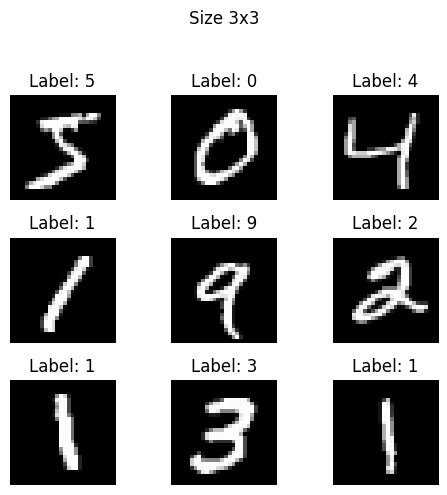

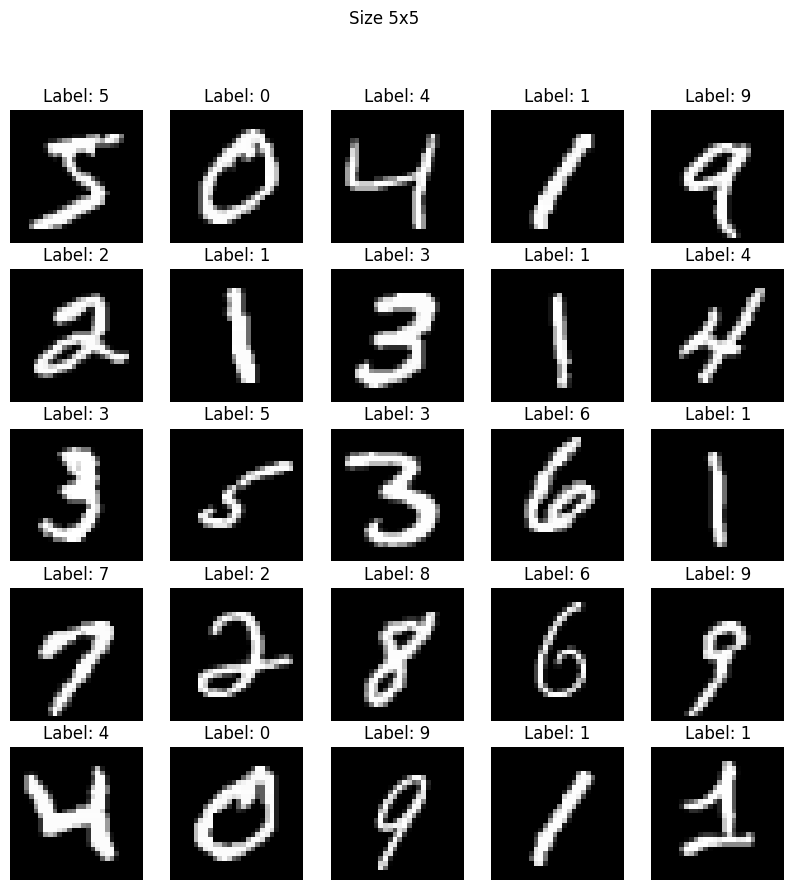

In [2]:
# @title 1. Ngeload data MNIST
# Load package
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# Load data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

plt.figure(figsize=(5,5))
plt.suptitle("Size 3x3")
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


plt.figure(figsize=(10,10))
plt.suptitle("Size 5x5")
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.show()

## 📋 Model yang rekomendasi

Berikut 4 base\_model yang bagus sebagai starting point:

1. **MobileNetV2**
   Ringan, performanya cukup bagus, cepat training dibanding model besar.

2. **EfficientNetB0**
   Lebih efisien (parameter vs akurasi bagus), cocok yang pengen balance.

3. **ResNet50V2**
   Lebih kompleks, bisa capture fitur lebih dalam.

4. **DenseNet121**
   Juga bagus menangkap fitur, skip connections, biasanya menghindari overfitting sedikit lebih baik.

Sumber: https://keras.io/api/applications/

In [3]:
# @title Model CNN
import tensorflow as tf
from tensorflow.keras import layers, models

x_train_cnn = x_train.reshape(-1, 28, 28, 1) / 255.0
x_test_cnn = x_test.reshape(-1, 28, 28, 1) / 255.0

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])



model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
              )

history = model.fit(x_train_cnn, y_train, epochs=5, validation_split=0.1)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 52s 30ms/step - accuracy: 0.8983 - loss: 0.3333 - val_accuracy: 0.9792 - val_loss: 0.0698
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 74s 26ms/step - accuracy: 0.9838 - loss: 0.0527 - val_accuracy: 0.9890 - val_loss: 0.0416
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 85s 27ms/step - accuracy: 0.9893 - loss: 0.0339 - val_accuracy: 0.9882 - val_loss: 0.0343
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 78s 25ms/step - accuracy: 0.9921 - loss: 0.0252 - val_accuracy: 0.9902 - val_loss: 0.0333
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 83s 25ms/step - accuracy: 0.9937 - loss: 0.0184 - val_accuracy: 0.9903 - val_loss: 0.0400


In [4]:
# @title SVM
from sklearn import svm
from sklearn.metrics import accuracy_score

# Flatten data dari 2D jadi 1D Vektor
x_train_flatten = x_train.reshape(len(x_train), -1) / 255.0
x_test_flatten = x_test.reshape(len(x_test), -1) / 255.0

# Training Model
clf = svm.SVC(kernel='rbf', gamma='scale') # RBF

# Gunakan subset karena SVM berat :)
# Batasi masing2 hanya 5000
clf.fit(x_train_flatten[:5000], y_train[:5000])

y_pred = clf.predict(x_test_flatten)

print("Akurasi RBF: ", accuracy_score(y_test, y_pred))

Akurasi RBF:  0.9513


In [5]:
# @title 2. Mendowload image testing
import requests
import os

# URL API untuk folder target
url = "https://api.github.com/repos/ImNotDanish05/2025_Visi-Komputer_TI-2A/contents/Asset02_KLASIFIKASI-GAMBAR"

# Folder lokal tempat simpan file
save_dir = "Data"
os.makedirs(save_dir, exist_ok=True)

# Get JSON list isi folder
response = requests.get(url)
files = response.json()

# Loop download tiap file
for file in files:
    if file["type"] == "file":  # pastikan itu file, bukan folder
        download_url = file["download_url"]
        file_name = os.path.join(save_dir, file["name"])

        print(f"Downloading {file['name']} ...")
        file_content = requests.get(download_url).content
        with open(file_name, "wb") as f:
            f.write(file_content)

print("✅ Semua file berhasil di-download!")


✅ Semua file berhasil di-download!


In [14]:
# ===== 2) Utilitas Preprocess agar mirip MNIST (28x28, putih-di-atas-hitam) =====
import numpy as np
from PIL import Image, ImageOps

def preprocess_to_mnist_28x28(img_pil):
    """
    - Preprocess ke format MNIST (28x28)
    - Return:
        disp = image (PIL.Image) siap ditampilkan
        arr  = numpy array (28,28,1) float [0,1]
    """

    # Grayscale + autocontrast
    img = img_pil.convert('L')
    img = ImageOps.autocontrast(img)

    arr = np.array(img).astype(np.uint8)

    # Invert bila background terang
    if arr.mean() > 127:
        img = ImageOps.invert(img)
        arr = np.array(img)

    # Cari bounding box digit
    thr = np.mean(arr) * 0.8
    mask = arr > thr
    if mask.any():
        ys, xs = np.where(mask)
        y0, y1 = ys.min(), ys.max()
        x0, x1 = xs.min(), xs.max()
        img = img.crop((x0, y0, x1 + 1, y1 + 1))

    # Resize ke 20x20 dengan aspect ratio
    img.thumbnail((20, 20), Image.Resampling.LANCZOS)
    w, h = img.size

    # Pad ke 28x28
    canvas = Image.new('L', (28, 28), color=0)
    canvas.paste(img, ((28 - w) // 2, (28 - h) // 2))

    # Simpan untuk display
    disp = canvas.copy()

    # Normalisasi ke [0,1]
    arr = np.array(canvas).astype('float32') / 255.0
    arr = arr[..., np.newaxis]   # (28,28,1)

    return disp, arr


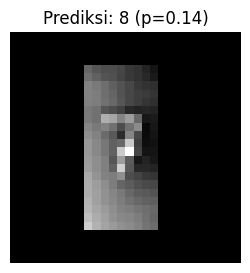

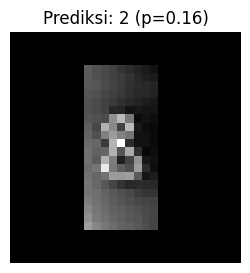

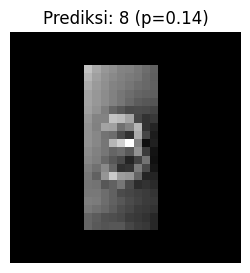

Rekap Prediksi (CNN):
- test3.jpeg -> 8 (p=0.142)
- test1.jpeg -> 2 (p=0.155)
- test2.jpeg -> 8 (p=0.140)


In [15]:
import os
import matplotlib.pyplot as plt

results = []

# Folder berisi gambar
folder_path = "Data"
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Loop tiap file di folder
for fname in image_files:
    img_path = os.path.join(folder_path, fname)
    img_pil = Image.open(img_path)

    # Preprocessing ke format MNIST
    disp, x = preprocess_to_mnist_28x28(img_pil)   # disp = buat ditampilkan, x = array (28,28,1)

    # Siapkan batch (1 sample)
    x_batch = np.expand_dims(x, axis=0)

    # Prediksi pakai model
    probs = model.predict(x_batch, verbose=0)[0]
    pred = int(np.argmax(probs))
    conf = float(np.max(probs))

    results.append((fname, pred, conf))

    # Tampilkan hasil prediksi untuk gambar
    plt.figure(figsize=(3, 3))
    plt.imshow(disp, cmap='gray')
    plt.title(f"Prediksi: {pred} (p={conf:.2f})")
    plt.axis('off')
    plt.show()

# Rekap ringkas
print("Rekap Prediksi (CNN):")
for r in results:
    print(f"- {r[0]} -> {r[1]} (p={r[2]:.3f})")

In [17]:
import os
from sklearn.metrics import accuracy_score

results = []

# Folder berisi gambar
folder_path = "Data"
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Loop tiap file di folder
for fname in image_files:
    img_path = os.path.join(folder_path, fname)
    img_pil = Image.open(img_path)

    # Preprocessing ke format MNIST (28x28, float [0,1])
    _, x = preprocess_to_mnist_28x28(img_pil)
    x_flat = x.reshape(1, -1)   # (1, 784)

    # Prediksi dengan SVM
    pred = int(clf.predict(x_flat)[0])

    # Coba ambil probabilitas (jika model dilatih dengan probability=True)
    conf = None
    try:
        if hasattr(clf, "predict_proba"):
            conf = float(np.max(clf.predict_proba(x_flat)))
    except Exception:
        pass

    results.append((fname, pred, conf))

    # Tampilkan hasil
    if conf is not None:
        print(f"{fname} -> Prediksi SVM: {pred} (p≈{conf:.2f})")
    else:
        print(f"{fname} -> Prediksi SVM: {pred}")

# Ringkasan hasil
print("\nRekap Prediksi (SVM):")
for r in results:
    print(f"- {r[0]} -> {r[1]}" + (f" (p≈{r[2]:.3f})" if r[2] is not None else ""))

test3.jpeg -> Prediksi SVM: 5
test1.jpeg -> Prediksi SVM: 5
test2.jpeg -> Prediksi SVM: 1

Rekap Prediksi (SVM):
- test3.jpeg -> 5
- test1.jpeg -> 5
- test2.jpeg -> 1
